# Agent Evaluation Visualization
This notebook will let you visualize agent pair's performance (score distributions)

#### Direction: If you would like to train/obtain custom AI / human model agents, please look into 
####          human_aware_rl/human_aware_rl/ppo/ppo_rllib_client.py, and 
####          human_aware_rl/human_aware_rl/imitation/behavior_cloning_tf2.py

## Premilinary imports and directory setups
#### Direction: You should run the following two cells regardless of which option you are using

In [1]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import itertools
from os import makedirs
from ray.tune.result import DEFAULT_RESULTS_DIR
from plot_utils import coloring_patches, plot_matrix, plot_single, plot_matrix_aug, plot_for_all_pairs, plot_sparse_rew_over_agent_pairs, plot_mean_std
from ipy_utils import parse_str_to_lst
from eval_utils import SAVE_DIR

In [2]:
# The path to stress_testing folder
LOAD_PATH = SAVE_DIR

# Whether to save the figures generated
SAVE_FIG = True


#### Direction: Now you should feel free to jump to the option you would like to run.

## Option 1: Fixed Layout from names, Mixed Play

### Step 0: Import

In [3]:
from ipy_utils import generate_eval_form_option_1, generate_eval_command_option_1, generate_visual_form_option_1, generate_visual_params_option_1

### Step 1: Input Evaluation Preference

In [4]:
eval_form_option_1 = generate_eval_form_option_1()
eval_form_option_1

Box(children=(Box(children=(Label(value='layout_name'), Text(value='cramped_room', placeholder='type the layou…

### Step 2: Generate command for evaluate.py

In [6]:
eval_params_option_1 = generate_eval_command_option_1(eval_form_option_1)

Evaluation params for option 1 {'layout_name': 'cramped_room', 'num_games': 1, 'mixed_play': True, 'ppo_sp_baseline_lst': ['11', '21', '31', '41'], 'custom_ai_cp_path_lst': []}
Please run the following commands:
---------
conda activate harl_rllib
python evaluate.py -l cramped_room -n 1 -m True -b 11 21 31 41 


### Step 3: Visualization Preference

In [7]:
visial_form_option_1 = generate_visual_form_option_1(LOAD_PATH, str(SAVE_FIG))
visial_form_option_1

Box(children=(Box(children=(Label(value='load_path'), Text(value='data/', placeholder='Enter the load path. De…

### Step 4: Get Visualization Params

In [8]:
visual_params_option_1 = generate_visual_params_option_1(visial_form_option_1)

print("visual_params_option_1: ", visual_params_option_1)

visual_params_option_1:  {'load_path': 'data/', 'data_timestamp': '1601959366.341098', 'custom_ai_cp_display_lst': [], 'save_fig': True}


### Step 5: Process Visualization Params

In [9]:
# initialize the agent display names
agent_display_option_1 = []

# if you use the baseline agents, we denote them by the random seed
agent_display_option_1 = agent_display_option_1 + eval_params_option_1['ppo_sp_baseline_lst']

# if you use custom checkpoints, we denote them by the last 2 letters
if len(visual_params_option_1["custom_ai_cp_display_lst"]) > 0:
    # if custom display is used, verify the lengths match up
    assert len(visual_params_option_1["custom_ai_cp_display_lst"]) == len(eval_params_option_1["custom_ai_cp_path_lst"]), "mismatch between length of display_name and path, display_name has length %d and path has length %d" %(len(visual_params_option_1["custom_ai_cp_display_lst"]), len(eval_params["custom_ai_cp_path_lst"]))
    custom_ai_display = visual_params_option_1["custom_ai_cp_display_lst"]
else:
    # else, use the last two letters of the experiment name
    custom_ai_display = [custom_cp_path.split('/')[-3][-2:] for custom_cp_path in eval_params_option_1["custom_ai_cp_path_lst"]]

agent_display_option_1 = agent_display_option_1 + custom_ai_display

print("agent_display_option_1: ", agent_display_option_1)

# The display name of the agent pairs
if eval_params_option_1["mixed_play"]:
    agent_pair_display_option_1 = [a + "\n+\n" + b for a, b in itertools.product(agent_display_option_1, agent_display_option_1)]
else:
    agent_pair_display_option_1 = [a + "\n+\n" + a for a in agent_display_option_1]
    
print("agent_pair_display_option_1: ", agent_pair_display_option_1)

# save_fig
save_fig = visual_params_option_1["save_fig"]

agent_display_option_1:  ['11', '21', '31', '41']
agent_pair_display_option_1:  ['11\n+\n11', '11\n+\n21', '11\n+\n31', '11\n+\n41', '21\n+\n11', '21\n+\n21', '21\n+\n31', '21\n+\n41', '31\n+\n11', '31\n+\n21', '31\n+\n31', '31\n+\n41', '41\n+\n11', '41\n+\n21', '41\n+\n31', '41\n+\n41']


['11', '21', '31', '41']


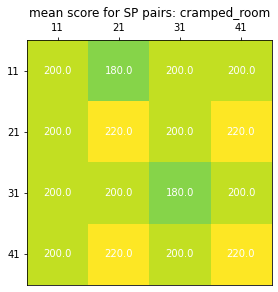

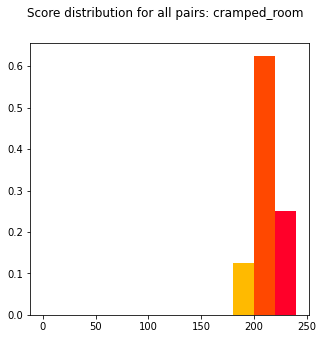

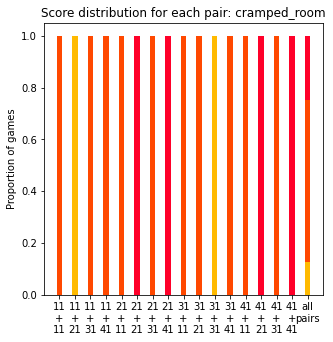

In [10]:
## Data loading

layout_name = eval_params_option_1["layout_name"]

# Whether the evaulation is mixed-play
mixed_play = eval_params_option_1["mixed_play"]

# how to display the agent
agent_display = agent_display_option_1

# how to display agent pairs
agent_pair_display = agent_pair_display_option_1

# The path to stress_testing folder
load_path = visual_params_option_1["load_path"]

# The time of the run
time_run = visual_params_option_1["data_timestamp"]

# Load numpy data
data_file = 'data' + time_run + '.npz'
data= np.load(load_path+data_file)

# Load layouts for display
layouts_file = 'layouts' + time_run + '.pkl'
with open(load_path+layouts_file, 'rb') as f:
    layouts = pickle.load(f)
layout = layouts[0]

# Load numpy data into the appropriate arrays
# index 0 because there is only 1 layout
sparse_reward_lst = data['sparse_reward_lst'][0]
sparse_reward_mean = data['sparse_reward_mean_lst'][0]
sparse_reward_std = data['sparse_reward_std_lst'][0]


num_agent = len(agent_display)

if mixed_play:
    assert len(agent_display) == math.sqrt(len(sparse_reward_mean)), "If you are not evaluating on mixed_play, please set the flag to False in the first form"
    sparse_reward_mean = np.reshape(sparse_reward_mean, (num_agent, num_agent))
    plot_matrix(agent_display, agent_display, sparse_reward_mean, "mean score", layout_name, save_fig=save_fig)

else:
    plot_single(sparse_reward_mean, sparse_reward_std, agent_pair_display, layout_name, save_fig=save_fig)

sparse_rew = sparse_reward_lst.flatten()
NUM_COLORS = int(np.max(sparse_rew) // 20) + 2
# create the bins
bins = [x * 20 for x in range(NUM_COLORS)]
plot_for_all_pairs(sparse_rew, layout_name, bins, save_fig=save_fig)

layout_info = {"layout_name": layout_name}
plot_sparse_rew_over_agent_pairs(sparse_reward_lst, agent_pair_display, layout_info, bins[1:], save_fig=save_fig)


## Option 2: Evaluate with Human Model

### Step 0: Import

In [11]:
from ipy_utils import generate_eval_form_option_2, generate_eval_command_option_2, generate_visual_form_option_2, generate_visual_params_option_2

### Step 1: Input Evaluation Preference

In [12]:
eval_form_option_2 = generate_eval_form_option_2()
eval_form_option_2

Box(children=(Box(children=(Label(value='layout_name'), Text(value='cramped_room', placeholder='type the layou…

### Step 2: Generate command for evaluate.py

In [13]:
eval_params_option_2 = generate_eval_command_option_2(eval_form_option_2)

Evaluation params for option 1 {'layout_name': 'cramped_room', 'num_games': 1, 'ppo_sp_baseline_lst': ['11', '21', '31', '41'], 'include_greedy_human': True, 'custom_ai_cp_path_lst': [], 'custom_h_cp_path_lst': []}
Please run the following commands:
---------
conda activate harl_rllib
python evaluate.py -l cramped_room -n 1 -b 11 21 31 41 -g True  


### Step 3: Visualization Preference

In [14]:
visial_form_option_2 = generate_visual_form_option_2(LOAD_PATH, str(SAVE_FIG))
visial_form_option_2

Box(children=(Box(children=(Label(value='load_path'), Text(value='data/', placeholder='Enter the load path. De…

### Step 4: Get Visualization Params

In [26]:
visual_params_option_2 = generate_visual_params_option_2(visial_form_option_2)
print("visual_params_option_2:", visual_params_option_2)

visual_params_option_2: {'load_path': 'data/', 'data_timestamp': '1601959015.9952784', 'custom_ai_cp_display_lst': [], 'custom_h_cp_display_lst': [], 'save_fig': True}


In [27]:
# populate the ai_agent_displays
ai_agent_display_option_2 = []

# if you use the baseline agents, we denote them by the random seed
ai_agent_display_option_2 = ai_agent_display_option_2 + eval_params_option_2['ppo_sp_baseline_lst']

# if you use custom checkpoints, we denote them by the last 2 letters
if len(visual_params_option_2["custom_ai_cp_display_lst"]) > 0:
    # if custom display is used, verify the lengths match up
    assert len(visual_params_option_2["custom_ai_cp_display_lst"]) == len(eval_params["custom_ai_cp_path_lst"]), "mismatch between length of display_name and path, display_name has length %d and path has length %d" %(len(visual_params_option_2["custom_ai_cp_display_lst"]), len(eval_params_option_2["custom_ai_cp_path_lst"]))
    custom_ai_display_option_2 = visual_params_option_2["custom_ai_cp_display_lst"]
else:
    # else, use the last two letters of the experiment name
    custom_ai_display_option_2 = [custom_cp_path.split('/')[-3][-2:] for custom_cp_path in eval_params_option_2["custom_ai_cp_path_lst"]]

ai_agent_display_option_2 = ai_agent_display_option_2 + custom_ai_display_option_2


# populate the h_agent_displays
h_agent_display_option_2 = []

# if using greedy agent, append the greedy agents's names
if eval_params_option_2['include_greedy_human']:
    h_agent_display_option_2 = h_agent_display_option_2 + ["default", "hl-0.2", "hl-1.0", "ll-0.2", "ll-1.0"]
    
# if you use custom checkpoints, we denote them by the last 2 letters
if len(visual_params_option_2["custom_h_cp_display_lst"]) > 0:
    # if custom display is used, verify the lengths match up
    assert len(visual_params_option_2["custom_h_cp_display_lst"]) == len(eval_params["custom_h_cp_path_lst"]), "mismatch between length of display_name and path, display_name has length %d and path has length %d" %(len(visual_params_option_2["custom_h_cp_display_lst"]), len(eval_params_option_2["custom_h_cp_path_lst"]))
    custom_ai_display_option_2 = visual_params_option_2["custom_h_cp_display_lst"]
else:
    # else, use the last two letters of the experiment name
    custom_ai_display_option_2 = [custom_cp_path.split('/')[-3][-2:] for custom_cp_path in eval_params_option_2["custom_h_cp_path_lst"]]
    
print("ai_agent_display_option_2: ", ai_agent_display_option_2)
print("h_agent_display_option_2: ", h_agent_display_option_2)

ai_agent_display_option_2:  ['11', '21', 'tx']
h_agent_display_option_2:  ['default', 'hl-0.2', 'hl-1.0', 'll-0.2', 'll-1.0']


### Step 5: Process Visualization Params

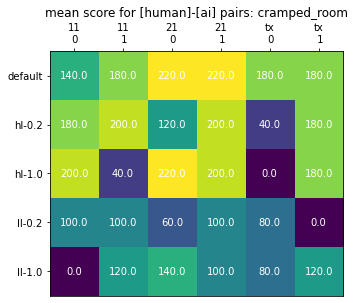

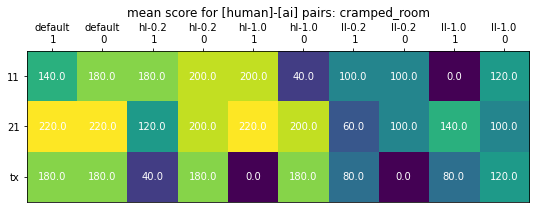

In [29]:
# layout name
layout_name = eval_params_option_2["layout_name"]

# reassign agent label
ai_agent_display = ai_agent_display_option_2

# agumented ai_gent_display
aug_ai_agent_display = []
for ai in ai_agent_display:
    aug_ai_agent_display.append(ai + "\n 0")
    aug_ai_agent_display.append(ai + "\n 1")

# The display name of the human model agents
human_agent_display = h_agent_display_option_2

aug_human_agent_display = []
for h in human_agent_display:
    aug_human_agent_display.append(h + "\n 1")
    aug_human_agent_display.append(h + "\n 0")
    
# The path to stress_testing folder
load_path = visual_params_option_2["load_path"]

# The time of the run
time_run = visual_params_option_2["data_timestamp"]

# Load numpy data
data_file = 'data' + time_run + '.npz'
data= np.load(load_path+data_file)

# Load layouts for display
layouts_file = 'layouts' + time_run + '.pkl'
with open(load_path+layouts_file, 'rb') as f:
    layouts = pickle.load(f)
layout = layouts[0]

# Load numpy data into the appropriate arrays
# index 0 because there is only 1 layout
sparse_reward_lst = data['sparse_reward_lst'][0]
sparse_reward_mean = data['sparse_reward_mean_lst'][0]
sparse_reward_std = data['sparse_reward_std_lst'][0]

# the factor of 2 is because we do revesed indexes too
num_human_agent = len(human_agent_display)
num_ai_agent = len(ai_agent_display)
num_ai_human_pairing = 2 * num_ai_agent * num_human_agent

sprase_reward_mean_paring = sparse_reward_mean[:num_ai_human_pairing]

sprase_reward_mean_paring = np.reshape(sprase_reward_mean_paring, (num_ai_agent, 2 * num_human_agent)).transpose()
by_human_model = np.zeros((num_human_agent, 2*num_ai_agent))

for i in range(num_human_agent):
    row1 = sprase_reward_mean_paring[2*i]
    row2 = sprase_reward_mean_paring[2*i+1]
    for j in range(num_ai_agent):
        by_human_model[i][2*j] = row1[j]
        by_human_model[i][2*j+1] = row2[j]

# plotting by human model
plot_matrix_aug(human_agent_display, aug_ai_agent_display, by_human_model, "mean score", layout_name, "human", save_fig=save_fig)

# plottin
plot_matrix_aug(ai_agent_display, aug_human_agent_display, sprase_reward_mean_paring.transpose(), "mean score", layout_name, "ai", save_fig=save_fig)